In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## scikit learn modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,\
    BaggingClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score


In [2]:
# Define column names
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']

# Read in the data
df = pd.read_csv('adult.data', header=None, names=col_names)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Investigate the data

In [7]:
# Calculate distribution of income values
df.income.value_counts(normalize=True)

income
 <=50K    0.75919
 >50K     0.24081
Name: proportion, dtype: float64

In [20]:
# Remove extra space at the beginning of all strings
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.strip()

In [22]:
# Convert categorical features to dummy variables
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

X = pd.get_dummies(df[feature_cols], drop_first=True)

# Create output variable
y = np.where(df.income == '<=50K', 0, 1)

In [23]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=1)

### Build and Tune Random Forest Classifiers by Depth

In [26]:
# Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)
print(round(test_accuracy, 5))

0.82021


In [27]:
# Tune the hyperparameter max_depth over a range from 1-25
np.random.seed(0)
accuracy_train = []
accuracy_test = []
depths = range(1, 26)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    accuracy_train.append(accuracy_score(y_train, y_pred_train))

In [29]:
# Find the best accuracy and at what depth that occurs
best_acc = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print('Highest accuracy is reached at depth: ', best_depth)
print('Highest accuracy on test set is: ', round(best_acc, 5))

Highest accuracy is reached at depth:  12
Highest accuracy on test set is:  0.83464


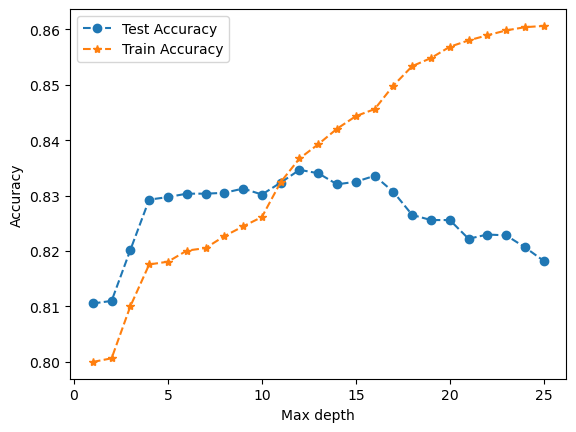

In [33]:
# Plot the accuracy scores for the test and train set over the range of depth values
plt.plot(depths, accuracy_test, '--o')
plt.plot(depths, accuracy_train, '--*')
plt.legend(['Test Accuracy', 'Train Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show()

In [36]:
# Refit the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)
feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_), 
                              columns=['Feature', 'Importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('Importance', ascending=False).iloc[:5])

Top 5 random forest features:
          Feature  Importance
1    capital-gain    0.370556
0             age    0.240393
3  hours-per-week    0.149522
2    capital-loss    0.142203
4        sex_Male    0.076306


### Create Additional Features and Re-Tune

In [37]:
# Create two new features, based on education
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], 
                             labels=['HS or less', 'College to Bachelors', 'Masters or more'])

In [38]:
# Convert categorical features to dummy variables
feature_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 
                'sex', 'race','education_bin']

X = pd.get_dummies(df[feature_cols], drop_first=True)

In [39]:
# Use the new additional feature and recreate test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [41]:
# Tune the hyperparameter max_depth over a range from 1-25 with the additional feature
np.random.seed(0)
accuracy_train = []
accuracy_test = []
depths = (1, 26)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(X_train, y_train)
    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    accuracy_train.append(accuracy_score(y_train, y_pred_train))

In [42]:
# Find the best max depth now with the additional feature
best_acc = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print('Highest accuracy is reached at depth: ', best_depth)
print('Highest accuracy on test set is: ', round(best_acc, 5))

Highest accuracy is reached at depth:  26
Highest accuracy on test set is:  0.83633


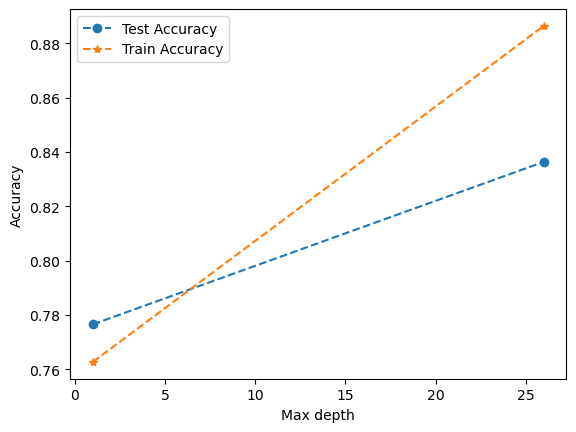

In [44]:
# Plot the accuracy scores for the test and train set over the range of depth values
plt.plot(depths, accuracy_test, '--o')
plt.plot(depths, accuracy_train, '--*')
plt.legend(['Test Accuracy', 'Train Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show()

In [45]:
# Save the best model and print the new feature set
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(X_train, y_train)
feature_imp_df = pd.DataFrame(zip(X_train.columns, best_rf.feature_importances_), 
                              columns = ['Feature', 'Importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('Importance', ascending=False).iloc[0:5])

Top 5 random forest features:
                          Feature  Importance
0                             age    0.306517
1                    capital-gain    0.232240
3                  hours-per-week    0.180953
2                    capital-loss    0.087789
10  education_bin_Masters or more    0.077732
